In [2]:
data=pd.read_csv('diabetes.csv')

In [3]:
data.sample(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
457,5,86,68,28,71,30.2,0.364,24,0
609,1,111,62,13,182,24.0,0.138,23,0
386,5,116,74,29,0,32.3,0.660,35,1
235,4,171,72,0,0,43.6,0.479,26,1
32,3,88,58,11,54,24.8,0.267,22,0


* There is no null value in this dataset

In [4]:
x=data.iloc[:,0:8]
y=data.iloc[:,-1]

In [5]:
x

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
0,6,148,72,35,0,33.6,0.627,50
1,1,85,66,29,0,26.6,0.351,31
2,8,183,64,0,0,23.3,0.672,32
3,1,89,66,23,94,28.1,0.167,21
4,0,137,40,35,168,43.1,2.288,33
...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63
764,2,122,70,27,0,36.8,0.340,27
765,5,121,72,23,112,26.2,0.245,30
766,1,126,60,0,0,30.1,0.349,47


In [6]:
y

0      1
1      0
2      1
3      0
4      1
      ..
763    0
764    0
765    0
766    1
767    0
Name: Outcome, Length: 768, dtype: int64

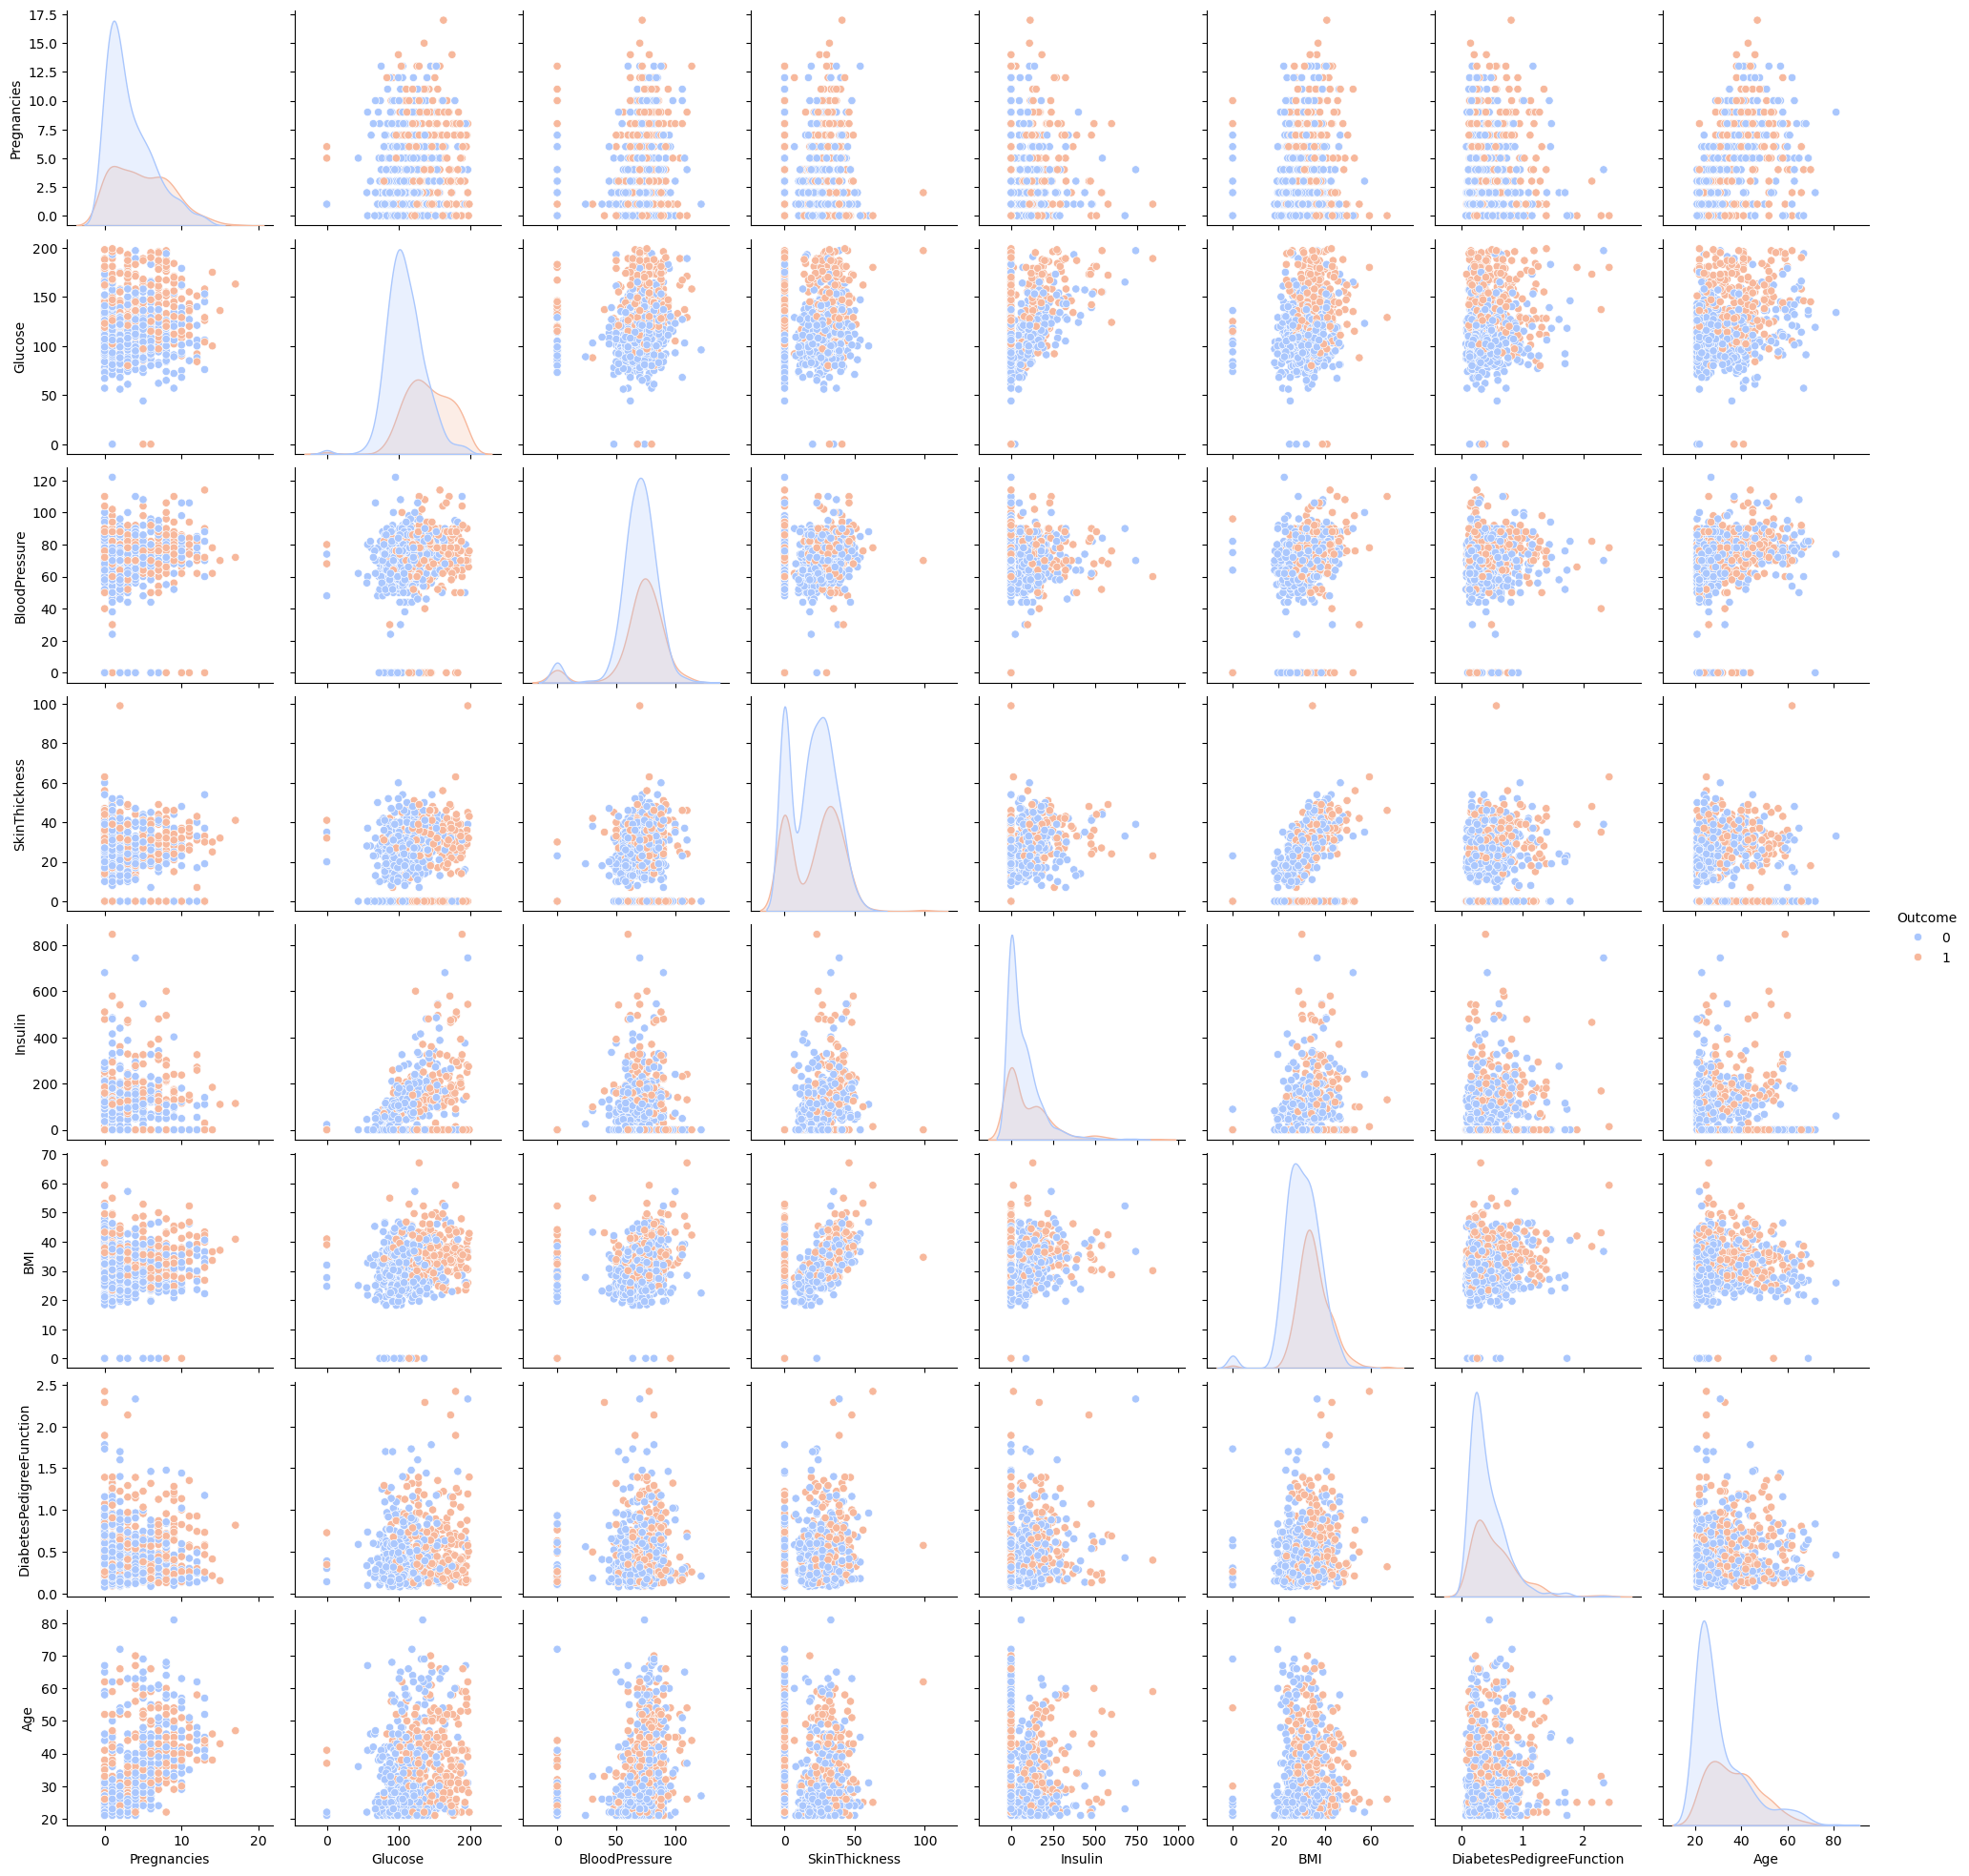

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")


sns.pairplot(data, hue='Outcome',  palette='coolwarm')


Text(0.5, 1.0, 'Correlation Heatmap Between Features')

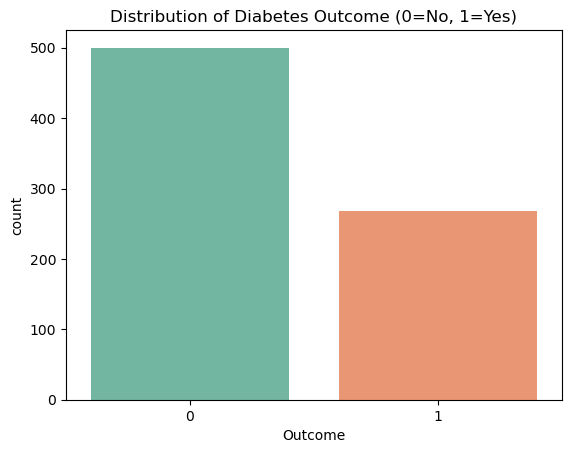

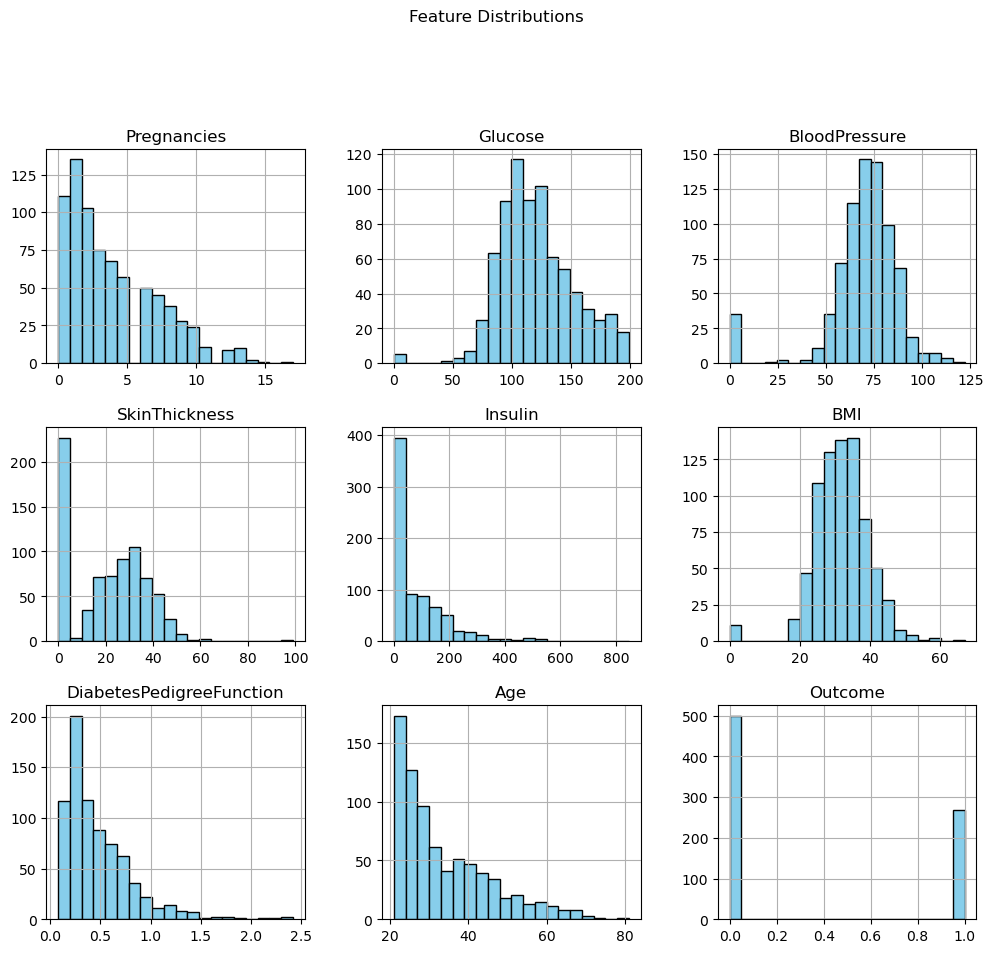

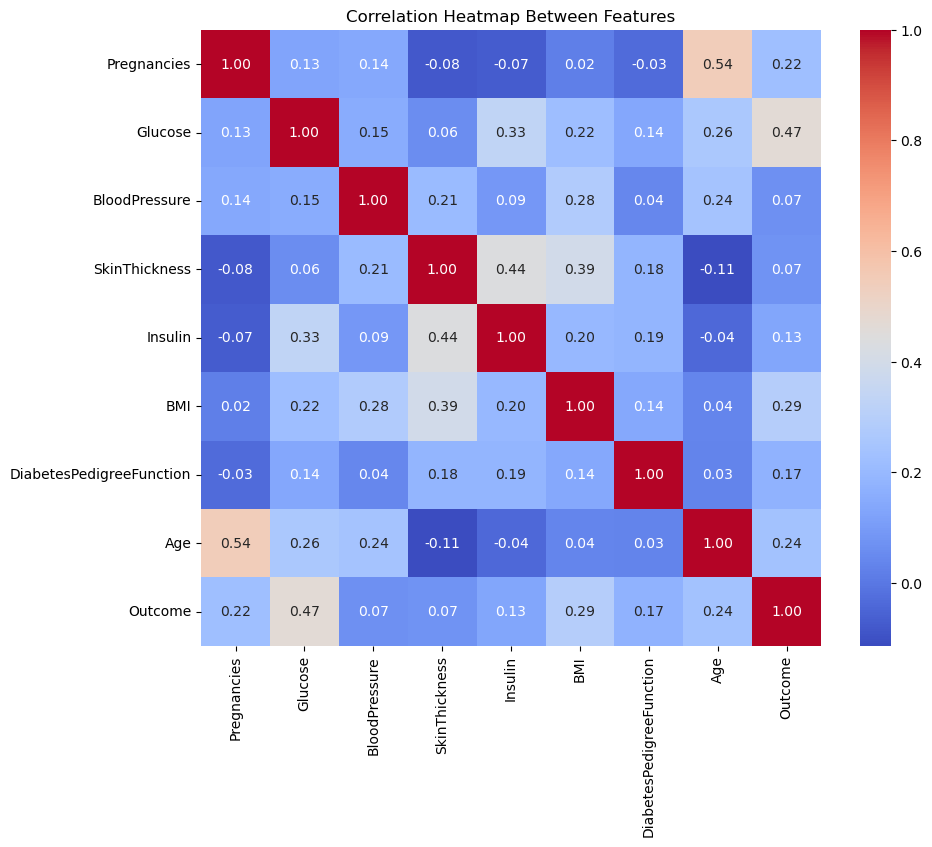

In [8]:
sns.countplot(x='Outcome', data=data, palette='Set2')
plt.title("Distribution of Diabetes Outcome (0=No, 1=Yes)")


data.hist(figsize=(12,10), bins=20, color='skyblue', edgecolor='black')
plt.suptitle("Feature Distributions", y=1.02)

plt.figure(figsize=(10,8))
sns.heatmap(data.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap Between Features")




Text(0.5, 1.0, 'Glucose vs BMI colored by Outcome')

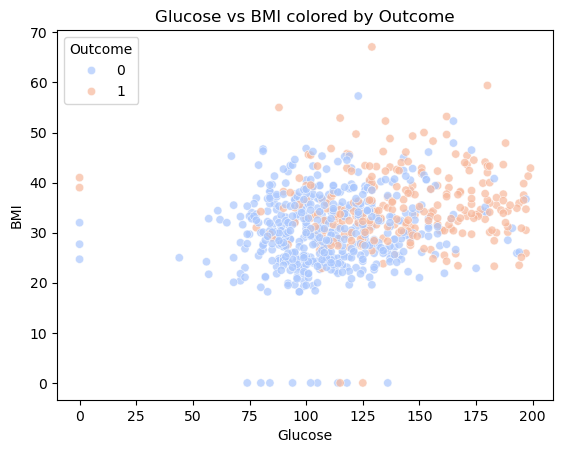

In [9]:
sns.scatterplot(x='Glucose', y='BMI', hue='Outcome', data=data, alpha=0.7, palette='coolwarm')
plt.title("Glucose vs BMI colored by Outcome")



In [67]:
from sklearn.linear_model import LinearRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.metrics  import recall_score,precision_score,accuracy_score
import joblib

In [68]:
x_train,x_test,y_train,y_test=train_test_split(x,y,random_state=42,test_size=0.3,stratify=y)

cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
sampler=ADASYN(random_state=42)
scaler=StandardScaler()

In [75]:
#for logistic regression 

pipe_lr=ImbPipeline([
    ('sampler', sampler),
    ('scaler', scaler),
    ('clf', LogisticRegression(max_iter=2000, random_state=42))
]) 

param_lr={
    'clf__C': [0.01, 0.1, 1], 
    'clf__class_weight': [None, 'balanced']  }

#for RandomForest
pipe_rf = ImbPipeline([
    ('sampler', sampler),
    ('clf', RandomForestClassifier(random_state=42, n_jobs=-1,class_weight='balanced_subsample'))
])  

param_rf = {
    'clf__n_estimators':[100, 200,300,400],
    'clf__max_depth': [5,6,7,8,9],
    'clf__min_samples_leaf': [1, 2]
}

# XGBoost
pipe_xgb = ImbPipeline([
    ('sampler', sampler),
    ('clf', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
param_xgb = {
    'clf__n_estimators': [100, 200,300,400],
    'clf__max_depth': [3, 4,5,6,7],
    'clf__learning_rate': [0.01, 0.05,0.1]
}
    

In [77]:
models={
    "LogisticRegression":(pipe_lr,param_lr),
    "RandomForest":(pipe_rf,param_rf),
    "XGboost":(pipe_xgb,param_xgb)
}
best_model=None
best_recall=0

for name,(pipe,grid) in models.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    search=GridSearchCV(estimator=pipe,param_grid=grid,scoring='recall',n_jobs=1,verbose=1,cv=cv)
    search.fit(x_train,y_train)
    
    y_pred = search.predict(x_test)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)

    print(f"Best Params: {search.best_params_}")
    print(f"Recall: {recall:.4f} | Precision: {precision:.4f} | Accuracy: {accuracy:.4f}")
    print("-" * 40)

    if recall > best_recall:
        best_recall = recall
        best_model = (name, search.best_estimator_)


model_name, model_obj = best_model
joblib.dump(model_obj, f"{model_name.replace(' ','_').lower()}_pipeline.joblib")
print(f"\n✅ Best model: {model_name} (Recall={best_recall:.4f}) saved successfully!")


========== Training LogisticRegression ==========
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best Params: {'clf__C': 0.1, 'clf__class_weight': 'balanced'}
Recall: 0.7407 | Precision: 0.6452 | Accuracy: 0.7662
----------------------------------------

========== Training RandomForest ==========
Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best Params: {'clf__max_depth': 5, 'clf__min_samples_leaf': 2, 'clf__n_estimators': 300}
Recall: 0.8272 | Precision: 0.6321 | Accuracy: 0.7706
----------------------------------------

========== Training XGboost ==========
Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Params: {'clf__learning_rate': 0.01, 'clf__max_depth': 3, 'clf__n_estimators': 300}
Recall: 0.8025 | Precision: 0.6190 | Accuracy: 0.7576
----------------------------------------

✅ Best model: RandomForest (Recall=0.8272) saved successfully!
